In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras
import pandas as pd
import seaborn as sb
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import math
import os

In [2]:
#Hyperparameters
taxi_epochs = 50
wind_epochs = 10
week_in_timesteps = 48*7
metric = [tf.keras.metrics.RootMeanSquaredError()]
patience = 10

# Time Series Forecasting with LSTM Networks

### Utility functions

In [3]:
#Callbacks for the model training
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()
reset_states = ResetStatesCallback()
early_stoppage = keras.callbacks.EarlyStopping(patience=patience)

In [4]:
#Plot data based on the dates given
def plot_series_by_date(series, start_date = '2014-07-01 00:30:00', end_date = '2015-01-31 23:30:00'):
  fig = plt.figure(figsize=(15,5))
  start_index = df[df['timestamp'] == pd.to_datetime(start_date, infer_datetime_format=True)].index.to_list()[0]
  end_index = df[df['timestamp'] == pd.to_datetime(end_date, infer_datetime_format=True)].index.to_list()[0]
  print(start_index)
  plt.plot(series['timestamp'][start_index:end_index],series['value'][start_index:end_index])
  plt.xlabel('Date')
  plt.ylabel('Traffic Volume')

In [5]:
#Helper function for easy plotting of time series
def plot_series(time, series, format="-", title = '',start=0, end=None, label=None, xlabel=None, ylabel=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.title(title)
    if xlabel is None:
      xlabel=""
    if ylabel is None:
      ylabel=''
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if label:
        plt.legend(fontsize=10)
    plt.grid(True)

In [6]:
# Returns the root mean squared error for two numpy arrays
def rmse(predictions : np.ndarray, targets : np.ndarray):
  return np.sqrt(((predictions - targets) ** 2).mean())

In [7]:
#Create benchmark dataset
def create_benchmark_forecast(sequence, n_steps_in, n_steps_out):
  X,y = list(), list()

  for pattern_start in range(0, len(sequence)):
    # finde the end of this pattern:
    pattern_end = pattern_start + n_steps_in
    prediction_end = pattern_end + n_steps_out
    #check if we are beyond the dataset:
    if prediction_end > len(sequence):
      break
    #gather input and output parts of the pattern
    if len(sequence.shape) == 1:
      seq_y = np.full(shape=n_steps_out, fill_value = sequence[pattern_end-1])
    else:
      seq_y = np.full(shape=n_steps_out, fill_value = sequence[pattern_end-1, -1])
    y.append(seq_y)
  return array(y)

In [8]:
#Create windowed dataset. Used for creating learning data of the LSTM models.
def create_windowed_datasets(sequences, n_steps_in, n_steps_out, sequence_to_sequence_RNN = False, is_stateful_network=False):
  X,y = list(), list()
  stride = 1
  if is_stateful_network:
      stride = n_steps_in
  for pattern_start in range(0, len(sequences), stride):
    # finde the end of this pattern:
    pattern_end = pattern_start + n_steps_in
    if sequence_to_sequence_RNN:
      prediction_start = pattern_start+1
    else:
      prediction_start = pattern_end
    prediction_end = pattern_end + n_steps_out
    #check if we are beyond the dataset:
    if prediction_end > len(sequences):
      break
    #gather input and output parts of the pattern
    if len(sequences.shape) == 1:
      seq_x, seq_y = sequences[pattern_start:pattern_end], sequences[prediction_start: prediction_end]
    else:
      seq_x, seq_y = sequences[pattern_start:pattern_end, :], sequences[prediction_start:(prediction_end), -1]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)


In [9]:
#Split data into train, validation and test data according to given percentages
def split_series(series : np.ndarray, train_percentage = 0.8, valid_percentage = 0.1, test_percentage = 0.1):
  length = series.shape[0]
  test = train_percentage * length
  train_split = math.ceil(train_percentage * length)
  valid_split = math.ceil((train_percentage + valid_percentage) * length)
  train_series = series[:train_split]
  valid_series = series[train_split:valid_split]
  test_series = series[valid_split:]
  return train_series, valid_series, test_series, train_split, valid_split

#### Utility tests

In [10]:
#Test data univariate
sequence = array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
print('Univariate Testdata: ', sequence)
#Test data multivariate
# multivariate data preparation
from numpy import array
from numpy import hstack
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95, 105])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
print('Multivariate Testdata: ', dataset)

Univariate Testdata:  [ 10  20  30  40  50  60  70  80  90 100]
Multivariate Testdata:  [[ 10  15  25]
 [ 20  25  45]
 [ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]
 [ 90  95 185]
 [100 105 205]]


In [11]:
#Test split series
train, valid, test, train_split, valid_split = split_series(sequence) 
assert np.array_equal(train, [10, 20, 30, 40, 50, 60, 70, 80])
assert np.array_equal(valid, [90])
assert np.array_equal(test, [100])
assert train_split == 8
assert valid_split == 9

In [12]:
#Test create_benchmark_dataset

In [13]:
result = create_benchmark_forecast(sequence=sequence, n_steps_in=4, n_steps_out=2)
expected = np.asarray([[40,40],[50, 50],[60, 60],[70, 70],[80, 80]], dtype=float)
assert np.array_equal(result, expected)
assert result.shape == (5,2)

In [14]:
result = create_benchmark_forecast(sequence=dataset, n_steps_in=4, n_steps_out=3)
assert result.shape == (4,3)

In [15]:
#Test create_windowed_dataset

In [16]:
X, Y = create_windowed_datasets(sequence, 3, 1, True, True)
assert X.shape == (3,3)
assert Y.shape == (3,3)
for i in range(len(Y)):
  print('X{}: '.format(i), X[i])
  print('Y{}: '.format(i), Y[i])

X0:  [10 20 30]
Y0:  [20 30 40]
X1:  [40 50 60]
Y1:  [50 60 70]
X2:  [70 80 90]
Y2:  [ 80  90 100]


In [17]:
X, Y = create_windowed_datasets(sequence, 5, 2, True)
assert X.shape == (4,5)
assert Y.shape == (4,6)
for i in range(len(Y)):
  print('X{}: '.format(i), X[i])
  print('Y{}: '.format(i), Y[i])

X0:  [10 20 30 40 50]
Y0:  [20 30 40 50 60 70]
X1:  [20 30 40 50 60]
Y1:  [30 40 50 60 70 80]
X2:  [30 40 50 60 70]
Y2:  [40 50 60 70 80 90]
X3:  [40 50 60 70 80]
Y3:  [ 50  60  70  80  90 100]


In [18]:
X, Y = create_windowed_datasets(sequence, 5, 2)
assert X.shape == (4,5)
assert Y.shape == (4,2)
for i in range(len(Y)):
  print('X{}: '.format(i), X[i])
  print('Y{}: '.format(i), Y[i])

X0:  [10 20 30 40 50]
Y0:  [60 70]
X1:  [20 30 40 50 60]
Y1:  [70 80]
X2:  [30 40 50 60 70]
Y2:  [80 90]
X3:  [40 50 60 70 80]
Y3:  [ 90 100]


In [19]:
X, Y = create_windowed_datasets(sequence, 5, 1)
assert X.shape == (5,5)
assert Y.shape == (5,1)
X, Y = create_windowed_datasets(sequence, 1, 5)
assert X.shape == (5,1)
assert Y.shape == (5,5)
X, Y = create_windowed_datasets(sequence, 9, 1)
assert X.shape == (1,9)
assert Y.shape == (1,1)
X, Y = create_windowed_datasets(sequence, 1, 9)
assert X.shape == (1,1)
assert Y.shape == (1,9)

In [20]:
X, Y = create_windowed_datasets(dataset, 5, 2)
assert X.shape == (4,5,3)
assert Y.shape == (4,2)

In [21]:
for i in range(len(Y)):
  print('X{}: '.format(i), X[i])
  print('Y{}: '.format(i), Y[i])

X0:  [[ 10  15  25]
 [ 20  25  45]
 [ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]]
Y0:  [125 145]
X1:  [[ 20  25  45]
 [ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]]
Y1:  [145 165]
X2:  [[ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]]
Y2:  [165 185]
X3:  [[ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]]
Y3:  [185 205]


In [22]:
X, Y = create_windowed_datasets(dataset, 4, 3)
assert X.shape == (4,4,3)
assert Y.shape == (4,3)
X, Y = create_windowed_datasets(dataset, 1, 8)
assert X.shape == (2,1,3)
assert Y.shape == (2,8)
X, Y = create_windowed_datasets(dataset, 2, 8)
assert X.shape == (1,2,3)
assert Y.shape == (1,8)
X, Y = create_windowed_datasets(dataset, 8, 2)
assert X.shape == (1,8,3)
assert Y.shape == (1,2)

## Univariate Time Series(Taxi Data)

#### Preprocessing data

In [23]:
#Load data
df = pd.read_csv('taxi.csv')
df['timestamp']=pd.to_datetime(df['timestamp'], infer_datetime_format=True)
timestamp = df['timestamp'].to_numpy()
series = df['value'].to_numpy()

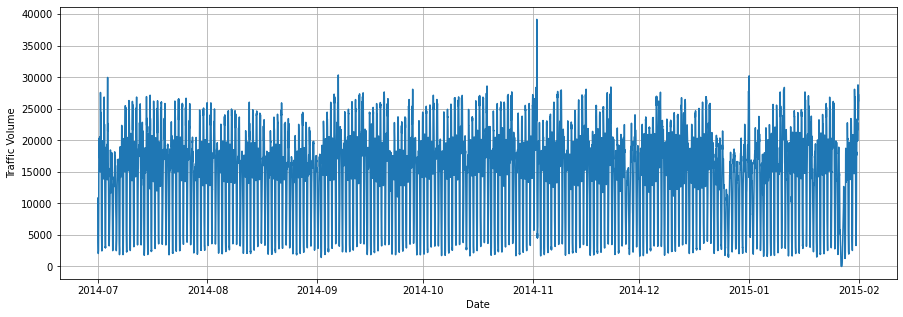

In [24]:
#Show complete data
fig = plt.figure(figsize=(15,5))
plot_series(timestamp, series, xlabel='Date', ylabel='Traffic Volume')

In [25]:
#Normalize data, so that all values are between 0 and 1
maximum = series.max()
f = lambda x: x/maximum
series = f(series)
time = df.index.to_numpy()

In [26]:
#Split in train, validate and test data
train_series, valid_series, test_series, train_split, valid_split = split_series(series, 0.8, 0.1, 0.1)
train_time, valid_time, test_time = range(train_split), range(train_split, valid_split), range(valid_split,series.shape[0])
print('series-Length: ', series.shape[0])
print('train_time: ', train_time)
print('valid_time: ',valid_time)
print('test_time: ', test_time)

series-Length:  10320
train_time:  range(0, 8256)
valid_time:  range(8256, 9288)
test_time:  range(9288, 10320)


### Single Step Forecasting using stacked LSTM

#### Data Preparation

In [27]:
# Split in train, validation and test data
keras.backend.clear_session()
# choose a number of time steps
n_steps_in, n_steps_out = 48, 1
n_features = 1
if len(valid_series.shape) > 1:
  n_features = valid_series.shape[1]
# split into samples
X_train, y_train  = create_windowed_datasets(train_series, n_steps_in, n_steps_out)
X_valid, y_valid  = create_windowed_datasets(valid_series, n_steps_in, n_steps_out)
X_test, y_test    = create_windowed_datasets(test_series, n_steps_in, n_steps_out)
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_valid: ', X_valid.shape)
print('y_valid: ', y_valid.shape)
print('X_valid: ', X_test.shape)
print('y_valid: ', y_test.shape)

X_train:  (8208, 48)
y_train:  (8208, 1)
X_valid:  (984, 48)
y_valid:  (984, 1)
X_valid:  (984, 48)
y_valid:  (984, 1)


#### Building and Training of the Model

In [28]:
tf.random.set_seed(42)
np.random.seed(42)

# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], n_features))

#Build model
model = keras.models.Sequential([
  keras.layers.LSTM(50, return_sequences=True, activation='relu', input_shape=[None, n_features]),
  keras.layers.LSTM(50, activation='relu'),
  keras.layers.Dense(n_steps_out),
  keras.layers.Lambda(lambda x: x * 200.0)
])

model.compile(loss=keras.losses.Huber(),
              optimizer= keras.optimizers.Adam(learning_rate = 1e-3),
              metrics=[metric])

model_checkpoint = keras.callbacks.ModelCheckpoint('singlevariate_singlestep.h5', save_best_only=True)

#Train model
history = model.fit(x=X_train,
                    y=y_train, 
                    epochs=taxi_epochs,
                    batch_size=32,
                    shuffle = True,
                    callbacks=[reset_states, model_checkpoint, early_stoppage],
                    validation_data=(X_valid, y_valid))

257/257 [==============================] - 32s 96ms/step - loss: 0.0392 - root_mean_squared_error: 0.3012 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0662


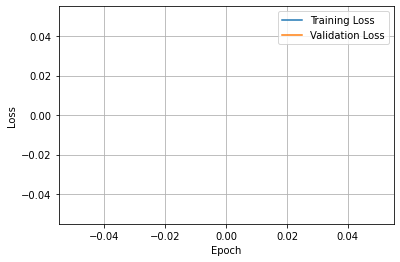

In [29]:
#Plot losses
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]
plot_series(range(len(loss)), loss, title='Loss over epochs', label='Training Loss')
plot_series(range(len(val_loss)), val_loss, xlabel='Epoch', ylabel='Loss', label='Validation Loss')
if not os.path.exists('Images'):
  os.makedirs('Images')
plt.savefig('Images/univariate_singlestep_training.eps', format='png')

#### Evaluation

In [30]:
# Load best model
model = keras.models.load_model("singlevariate_singlestep.h5")

In [31]:
#Evaluate model
model.evaluate(x=X_test, y=y_test)

31/31 [==============================] - 1s 15ms/step - loss: 0.0028 - root_mean_squared_error: 0.0748


[0.002797396620735526, 0.0747983530163765]

In [32]:
rnn_forecast = model.predict(X_test)
rnn_forecast.shape

31/31 [==============================] - 1s 14ms/step


(984, 1)

In [33]:
rnn_forecast = rnn_forecast.reshape(-1)
rnn_forecast.shape

(984,)

In [34]:
test_series_plt = test_series[n_steps_in:]
test_series_plt.shape

(984,)

In [35]:
rnn_forecast_plt = rnn_forecast[:-1]
test_series_plt = test_series_plt[1:]
print(rnn_forecast_plt.shape)
print(test_series_plt.shape)

(983,)
(983,)


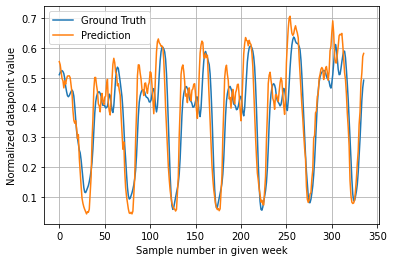

In [36]:
time = range(len(rnn_forecast_plt))
plot_series(time, rnn_forecast_plt, format='-', start = 0, end = week_in_timesteps, label='Ground Truth')
plot_series(time,test_series_plt, format='-', start = 0, end = week_in_timesteps, label='Prediction', xlabel='Sample number in given week', ylabel='Normalized datapoint value')
if not os.path.exists('Images'):
  os.makedirs('Images')
plt.savefig('Images/univariate_singlestep_prediction.eps', format='eps')

#### Benchmark Test
In order to see, how well our model performs, we us an naive forecast as benchmark. The benchmark just uses the value of the timestep before as prediction for the next day.

In [37]:
#Create benchmark series
bench_series = series[valid_split-1:-1]
bench_series.shape

(1032,)

In [38]:
test_series.shape

(1032,)

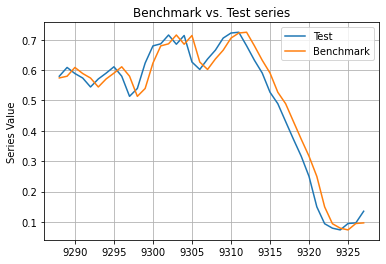

In [39]:
#Plot naive forecast vs Ground Truth
plot_series(test_time, test_series, format='-', end = 40, label = 'Test')
plot_series(test_time, bench_series, format='-', end = 40, label = 'Benchmark', ylabel= 'Series Value')
plt.title('Benchmark vs. Test series');

In [40]:
#Compute RMSE
rmse(test_series, bench_series)

0.04239106817396882

### Multi Step Forecasting using stacked LSTM

#### Data Preparation

In [41]:
keras.backend.clear_session()
# choose a number of time steps
n_steps_in, n_steps_out = 2*48, 48
n_features =1
if len(valid_series.shape) > 1:
  n_features==valid_series.shape[1]
# split into samples
# split into samples
X_train, y_train  = create_windowed_datasets(train_series, n_steps_in, n_steps_out)
X_valid, y_valid  = create_windowed_datasets(valid_series, n_steps_in, n_steps_out)
X_test, y_test    = create_windowed_datasets(test_series, n_steps_in, n_steps_out)
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_valid: ', X_valid.shape)
print('y_valid: ', y_valid.shape)
print('X_valid: ', X_test.shape)
print('y_valid: ', y_test.shape)

X_train:  (8113, 96)
y_train:  (8113, 48)
X_valid:  (889, 96)
y_valid:  (889, 48)
X_valid:  (889, 96)
y_valid:  (889, 48)


#### Building and Training of the Model

In [42]:
#Reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], n_features))

#Define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(None, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(n_steps_out))
model.add(keras.layers.Lambda(lambda x: x * 200.0))
model.compile(loss=keras.losses.Huber(),
              optimizer=keras.optimizers.Adam(learning_rate = 1e-3),
              metrics=[metric])

#Fit model
model_checkpoint = keras.callbacks.ModelCheckpoint('univariate_multistep.h5')
history = model.fit(x=X_train,
                    y=y_train, 
                    epochs=taxi_epochs,
                    batch_size=32,
                    shuffle = True,
                    callbacks=[reset_states, model_checkpoint, early_stoppage],
                    validation_data=(X_valid, y_valid))

254/254 [==============================] - 29s 100ms/step - loss: 0.0482 - root_mean_squared_error: 0.4046 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1557


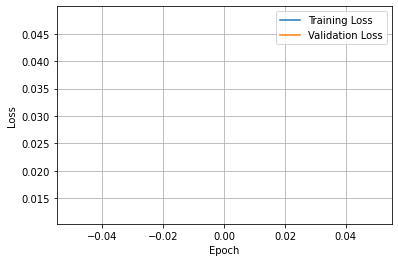

In [43]:
#Plot loss
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_series(range(len(loss)), loss, title='Loss over epochs', label='Training Loss')
plot_series(range(len(val_loss)), val_loss, xlabel='Epoch', ylabel='Loss', label='Validation Loss')

#### Evaluation

In [44]:
#Load best model
model = keras.models.load_model("univariate_multistep.h5")

In [45]:
#Evaluate model (RMSE)
model.evaluate(x=X_test, y=y_test)

28/28 [==============================] - 1s 24ms/step - loss: 0.0161 - root_mean_squared_error: 0.1792


[0.01606171950697899, 0.17923010885715485]

In [46]:
rnn_forecast = model.predict(X_test)
print(rnn_forecast.shape)


28/28 [==============================] - 1s 24ms/step
(889, 48)


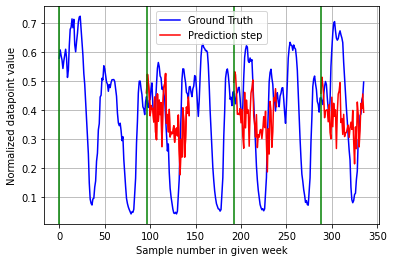

In [47]:
time = range(test_series.shape[0])
plot_series(time, test_series, format='b-', end = week_in_timesteps, label='Ground Truth')

for index in range(0,week_in_timesteps,96):
  plt.axvline(x = index, color = 'g')
  if index < 95:
    plot_series(range(index + n_steps_in,index + n_steps_in + n_steps_out), rnn_forecast[index], format='r-', label='Prediction step')
  if index < week_in_timesteps-96:
    plot_series(range(index + n_steps_in,index + n_steps_in + n_steps_out), rnn_forecast[index], format='r-',xlabel='Sample number in given week', ylabel='Normalized datapoint value')
if not os.path.exists('Images'):
  os.makedirs('Images')
plt.savefig('Images/univariate_multistep_prediction.eps', format='eps')

#### Benchmark Test
In order to see, how well our model performs, we us an naive forecast as benchmark. The benchmark just uses the value of the timestep before as prediction for the n prediction steps.

In [48]:
#Create prediction series
y_pred = model.predict(X_test)

28/28 [==============================] - 1s 24ms/step


In [49]:
#Create benchmark series
y_pred = model.predict(X_test)
y_bench = create_benchmark_forecast(test_series, n_steps_in, n_steps_out)
print('y_test.shape: ', y_test.shape)
print('y_bench.shape: ', y_bench.shape)
print('y_pred.shape: ', y_pred.shape)

28/28 [==============================] - 1s 26ms/step
y_test.shape:  (889, 48)
y_bench.shape:  (889, 48)
y_pred.shape:  (889, 48)


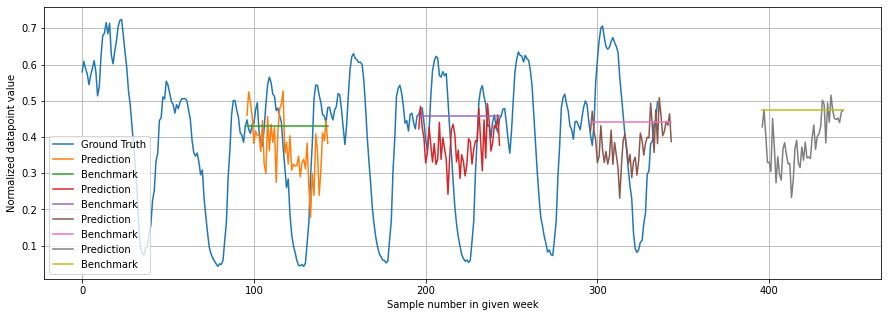

In [50]:
fig = plt.figure(figsize=(15,5))
end = week_in_timesteps
plot_series(range(test_series.shape[0]), test_series, end=end, label='Ground Truth')

for index in range(0,end,100):
  plot_series(range(index + n_steps_in,index + n_steps_in + n_steps_out), y_pred[index], format='-', label='Prediction')
  plot_series(range(index + n_steps_in,index + n_steps_in + n_steps_out), y_bench[index], format='-',label='Benchmark', xlabel='Sample number in given week', ylabel='Normalized datapoint value')
if not os.path.exists('Images'):
  plt.grid(visible=True, axis='both')

In [51]:
print('Prediction RMSE: ', rmse(y_test, y_pred))
print('Benchmark RMSE: ', rmse(y_test, y_bench))

Prediction RMSE:  0.1792301266108851
Benchmark RMSE:  0.24472222583450468


## Multivariate Time Series (Wind data)

### Preprocessing Data

In [52]:
#Load data
df = pd.read_csv('wind.csv')

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     6574 non-null   object 
 1   WIND     6574 non-null   float64
 2   IND      6574 non-null   int64  
 3   RAIN     6574 non-null   float64
 4   IND.1    6513 non-null   float64
 5   T.MAX    5953 non-null   float64
 6   IND.2    6513 non-null   float64
 7   T.MIN    5900 non-null   float64
 8   T.MIN.G  6214 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 462.4+ KB


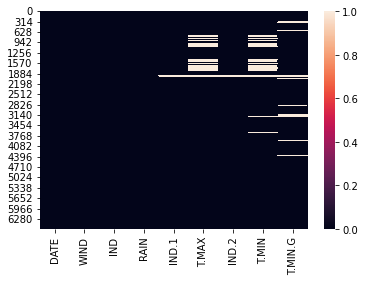

In [54]:
#Create heatmap
sb.heatmap(df.isnull())

We wil fill all NaN cells with the previous value, since we assume, that wheather only changes slowly.

In [55]:
df = df.fillna(method='ffill');

Since all dates are adjacent, we can drop date column. Also we change datatype of column IND.1 to float 64

In [56]:
df = df.drop(labels=['DATE'], axis=1)

In [57]:
df['IND'] = df['IND'].astype('float64')

Finally put the wind speed column at the last position and normalize each column with its maximum absolute value.

In [58]:
columns_titles = ['IND', 'RAIN', 'IND.1','T.MAX', 'IND.2', 'T.MIN', 'T.MIN.G', 'WIND']
df=df.reindex(columns=columns_titles)

In [59]:
import math
train_percentage = 0.8
series = df.to_numpy()
#Split in train, validate and test data
train_series, valid_series, test_series, train_split, valid_split = split_series(series, 0.8, 0.1, 0.1)
train_time, valid_time, test_time = range(train_split), range(train_split, valid_split), range(valid_split,series.shape[0])
print('Train data shape: ', train_series.shape)
print('Validation data shape: ', valid_series.shape)
print('Test data shape: ', test_series.shape)
print('series-Length: ', series.shape[0])
print('train_time: ', train_time)
print('valid_time: ',valid_time)
print('test_time: ', test_time)



Train data shape:  (5260, 8)
Validation data shape:  (657, 8)
Test data shape:  (657, 8)
series-Length:  6574
train_time:  range(0, 5260)
valid_time:  range(5260, 5917)
test_time:  range(5917, 6574)


### Single Time Step Forecasting using stacked LSTM

#### Data Preparation

In [60]:
keras.backend.clear_session()
# choose a number of time steps
n_steps_in, n_steps_out = 20, 1
if len(valid_series.shape) > 1:
  n_features==valid_series.shape[1]
# split into samples
X_train, y_train  = create_windowed_datasets(train_series, n_steps_in, n_steps_out)
X_valid, y_valid  = create_windowed_datasets(valid_series, n_steps_in, n_steps_out)
X_test, y_test    = create_windowed_datasets(test_series, n_steps_in, n_steps_out)
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_valid: ', X_valid.shape)
print('y_valid: ', y_valid.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (5240, 20, 8)
y_train:  (5240, 1)
X_valid:  (637, 20, 8)
y_valid:  (637, 1)
X_test:  (637, 20, 8)
y_test:  (637, 1)


#### Building and Training of the Model

In [61]:
from keras.callbacks import learning_rate_schedule
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20))
n_steps_in = X_train.shape[1]
n_features = X_train.shape[2]
n_steps_out= y_train.shape[1]

# define model
model = keras.Sequential()
model.add(keras.layers.LSTM(15, activation='relu', return_sequences=True, input_shape=(None, n_features)))
model.add(keras.layers.LSTM(15, activation='relu'))
model.add(keras.layers.Dense(n_steps_out))
model.add(keras.layers.Lambda(lambda x: x * 200.0))
model.compile(loss=keras.losses.Huber(),
              optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
              metrics=[metric])

model_checkpoint = keras.callbacks.ModelCheckpoint('multivariate_singlestep.h5', save_best_only=True)

# fit model
history = model.fit(x = X_train, 
                    y = y_train,
                    epochs=wind_epochs,
                    shuffle=True,
                    batch_size=32,
                    callbacks = [model_checkpoint, reset_states, early_stoppage],
                    validation_data=(X_valid, y_valid))

164/164 [==============================] - 7s 24ms/step - loss: 199.7930 - root_mean_squared_error: 96.8868 - val_loss: 69.4749 - val_root_mean_squared_error: 246.4532


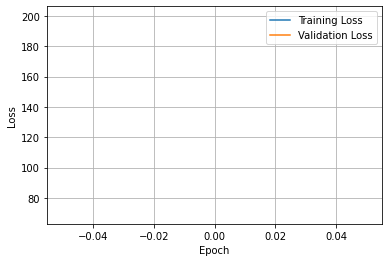

In [62]:
#Plot losses
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_series(range(len(loss)), loss, title='Loss over epochs', label='Training Loss')
plot_series(range(len(val_loss)), val_loss, xlabel='Epoch', ylabel='Loss', label='Validation Loss')

#### Evaluation

In [63]:
#Load best model
model = keras.models.load_model('multivariate_singlestep.h5')

In [64]:
#Evaluate model
model.evaluate(x=X_test, y=y_test)

20/20 [==============================] - 1s 6ms/step - loss: 52.2506 - root_mean_squared_error: 67.7316


[52.25061798095703, 67.73159790039062]

In [65]:
rnn_forecast = model.predict(X_test)
rnn_forecast = rnn_forecast.reshape(-1)
rnn_forecast_plt = rnn_forecast[:-1]
print(rnn_forecast_plt.shape)

20/20 [==============================] - 0s 5ms/step
(636,)


In [66]:
test_series_plt = test_series[n_steps_in:,-1]
test_series_plt = test_series_plt[1:]
test_series_plt.shape

(636,)

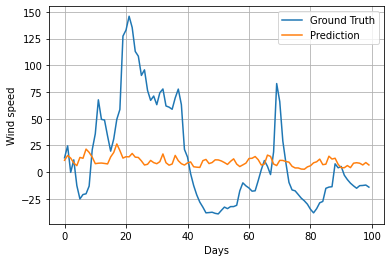

In [67]:
time = range(len(rnn_forecast_plt))
end = 100
plot_series(time, rnn_forecast_plt, format='-', start = 0, end = end, label='Ground Truth')
plot_series(time,test_series_plt, format='-', start = 0, end = end, label='Prediction', xlabel='Days', ylabel='Wind speed')


if not os.path.exists('Images'):
  os.makedirs('Images')
plt.savefig('Images/multivariate_singlestep_prediction.eps', format='eps')

#### Benchmark Test
In order to see, how well our model performs, we us an naive forecast as benchmark. The benchmark just uses the value of the timestep before as prediction for the next day.

In [68]:
#Create benchmark series
bench_series = series[valid_split-1:-1, -1]
bench_series.shape

(657,)

In [69]:
test_series_reshaped = test_series[:,-1]

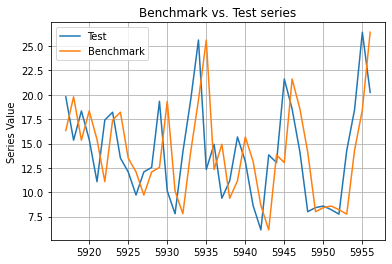

In [70]:
plot_series(test_time, test_series_reshaped, format='-', end = 40, label = 'Test')
plot_series(test_time, bench_series, format='-', end = 40, label = 'Benchmark', ylabel= 'Series Value')
plt.title('Benchmark vs. Test series');

In [71]:
rmse(test_series_reshaped, bench_series)

4.554987665535564

### Multi Step Forecasting

#### Data Preparation

In [72]:
keras.backend.clear_session()
# choose a number of time steps
n_steps_in, n_steps_out = 10, 3
n_features =1
if len(valid_series.shape) > 1:
  n_features==valid_series.shape[1]

# split into samples
X_train, y_train  = create_windowed_datasets(train_series, n_steps_in, n_steps_out)
X_valid, y_valid  = create_windowed_datasets(valid_series, n_steps_in, n_steps_out)
X_test, y_test    = create_windowed_datasets(test_series, n_steps_in, n_steps_out)
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_valid: ', X_valid.shape)
print('y_valid: ', y_valid.shape)
print('X_valid: ', X_test.shape)
print('y_valid: ', y_test.shape)

X_train:  (5248, 10, 8)
y_train:  (5248, 3)
X_valid:  (645, 10, 8)
y_valid:  (645, 3)
X_valid:  (645, 10, 8)
y_valid:  (645, 3)


#### Building and Training of the Model

In [73]:
n_steps_in = X_train.shape[1]
n_features = X_train.shape[2]
n_steps_out= y_train.shape[1]

# define model
model = keras.Sequential()
model.add(keras.layers.LSTM(10, activation='relu', return_sequences=True, input_shape=(None, n_features)))
model.add(keras.layers.LSTM(10, activation='relu'))
model.add(keras.layers.Dense(n_steps_out))
model.add(keras.layers.Lambda(lambda x: x * 200.0))
model.compile(loss=keras.losses.Huber(),
              optimizer='adam',
              metrics=[metric])

model_checkpoint = keras.callbacks.ModelCheckpoint('multivariate_multistep.h5', save_best_only=True)

# fit model
history = model.fit(x = X_train, 
                    y = y_train,
                    epochs=wind_epochs,
                    shuffle=True,
                    batch_size=32,
                    callbacks = [model_checkpoint, reset_states, early_stoppage],
                    validation_data=(X_valid, y_valid))

164/164 [==============================] - 5s 14ms/step - loss: 157.1778 - root_mean_squared_error: 417.1163 - val_loss: 29.2019 - val_root_mean_squared_error: 52.3208


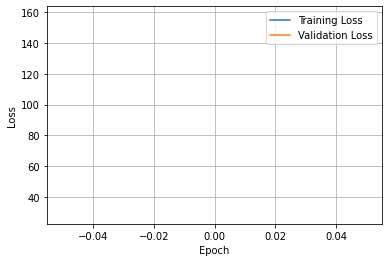

In [74]:
#Plot losses
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_series(range(len(loss)), loss, title='Loss over epochs', label='Training Loss')
plot_series(range(len(val_loss)), val_loss, xlabel='Epoch', ylabel='Loss', label='Validation Loss')

#### Evaluation

In [75]:
#Load best model
model = keras.models.load_model("multivariate_multistep.h5")

In [76]:
#Evaluate model
model.evaluate(x=X_test, y=y_test)

21/21 [==============================] - 1s 5ms/step - loss: 34.6304 - root_mean_squared_error: 61.4874


[34.63035202026367, 61.48740005493164]

In [77]:
rnn_forecast = model.predict(X_test)
print(rnn_forecast.shape)


21/21 [==============================] - 0s 4ms/step
(645, 3)


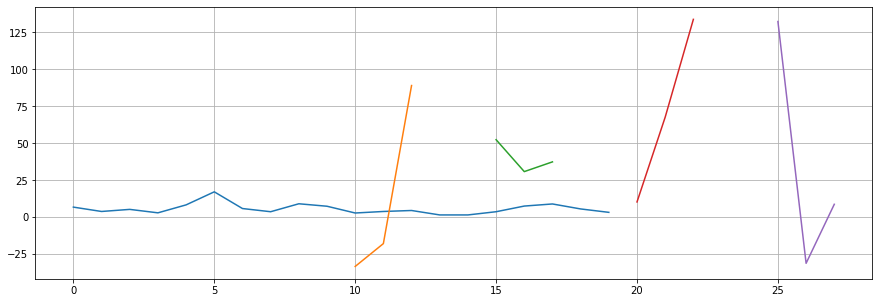

In [78]:
fig = plt.figure(figsize=(15,5))
end = 20
plot_series(range(len(valid_series))[0:end], valid_series[0:end,-1])

for index in range(0,end,5):
  plot_series(range(index + n_steps_in,index + n_steps_in + n_steps_out), rnn_forecast[index])
  plt.grid(visible=True, axis='both')

#### Benchmark Test
In order to see, how well our model performs, we us an naive forecast as benchmark. The benchmark just uses the value of the timestep before as prediction for the n prediction steps.

In [79]:
#Create prediction series
y_pred = model.predict(X_test)

21/21 [==============================] - 0s 3ms/step


In [80]:
#Create benchmark series
y_pred = model.predict(X_test)
y_bench = create_benchmark_forecast(test_series, n_steps_in, n_steps_out)
print('y_test.shape: ', y_test.shape)
print('y_bench.shape: ', y_bench.shape)
print('y_pred.shape: ', y_pred.shape)

21/21 [==============================] - 0s 3ms/step
y_test.shape:  (645, 3)
y_bench.shape:  (645, 3)
y_pred.shape:  (645, 3)


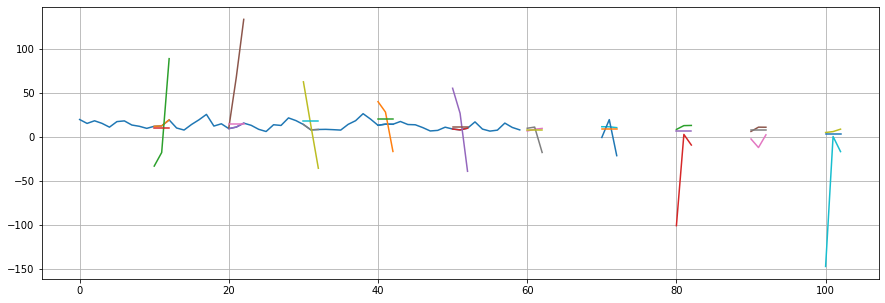

In [81]:
fig = plt.figure(figsize=(15,5))
end = 100
plot_series(range(len(test_series))[0:60], test_series[0:60,-1])

for index in range(0,end,10):
  plot_series(range(index + n_steps_in,index + n_steps_in + n_steps_out), y_test[index], format='-')
  plot_series(range(index + n_steps_in,index + n_steps_in + n_steps_out), y_pred[index], format='-')
  plot_series(range(index + n_steps_in,index + n_steps_in + n_steps_out), y_bench[index], format='-')
  plt.grid(visible=True, axis='both')

In [82]:
print('Prediction RMSE: ', rmse(y_test, y_pred))
print('Benchmark RMSE: ', rmse(y_test, y_bench))

Prediction RMSE:  61.48740081875952
Benchmark RMSE:  5.622998276044827
